# 评估与可视化

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils

In [2]:
FILE_PATH = './data'
CSV_FILE = 'user.csv'
COMPONENT_FILE = 'component/part-00000-*.csv'
GROUP_SIZE = 3

## 1. 异常检测

由于黑产存在资源复用，导致其使用的 uid 之间 Jaccard similarity 相似度较高。用这些相似节点构图，然后计算社区，黑产 uid 组成的社区规模会比正常 uid 组成的社区更大。

In [3]:
component_path = utils.gen_abspath(FILE_PATH, COMPONENT_FILE)
component_path = glob.glob(component_path)[0]
cdf = utils.read_csv(component_path)
cdf

,id,component,size
0,-35,-47,37
1,-13,-47,37
2,-33,-47,37
3,-20,-47,37
4,-21,-47,37
5,-17,-47,37
6,-10,-47,37
7,-11,-47,37
8,-15,-47,37
9,-37,-47,37


In [4]:
# 把 size 大于等于 GROUP_SIZE 的归为异常
cdf[cdf['size'] >= GROUP_SIZE]

,id,component,size
0,-35,-47,37
1,-13,-47,37
2,-33,-47,37
3,-20,-47,37
4,-21,-47,37
5,-17,-47,37
6,-10,-47,37
7,-11,-47,37
8,-15,-47,37
9,-37,-47,37


In [5]:
# 被判为异常的 uid
fraud_uid_list = list(set(cdf[cdf['size'] >= GROUP_SIZE]['id'].tolist()))
fraud_uid_list

[-47,
 -43,
 -41,
 -39,
 -37,
 -36,
 -35,
 -34,
 -33,
 -32,
 -31,
 -30,
 -26,
 -25,
 -24,
 -23,
 -22,
 -21,
 -20,
 -19,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -1,
 -2]

## 2. 模型评估

计算 SynchroTrap 算法的 准确率、精确率、召回率 等指标。

In [6]:
# 加载原始日志数据
csv_path = utils.gen_abspath(directory=FILE_PATH, rel_path=CSV_FILE)
df = utils.read_csv(csv_path)
df

,uid,ipv4,time,timestamp
0,851,98.245.3.124,2024-07-31 11:37:55,1722397075
1,227,253.155.228.78,2024-07-31 11:38:18,1722397098
2,240,3.114.70.213,2024-07-31 11:38:37,1722397117
3,972,32.107.120.156,2024-07-31 11:38:52,1722397132
4,915,254.252.255.168,2024-07-31 11:39:00,1722397140
...,...,...,...,...
2484,503,118.219.88.27,2024-07-31 18:50:19,1722423019
2485,133,125.54.141.195,2024-07-31 18:50:29,1722423029
2486,425,157.168.234.253,2024-07-31 18:50:37,1722423037
2487,183,53.120.190.145,2024-07-31 18:50:42,1722423042


In [7]:
# 获取 uid 列表
# uid 大于等于 0 为正常数据，小于 0 为异常数据
uid_list = sorted(list(set(df['uid'].tolist())))

# 计算 y_true
# 正常标记为 0，异常标记为 1
y_true = [0 if e >= 0 else 1 for e in uid_list]

# 计算 y_label
y_label = [1 if e in fraud_uid_list else 0 for e in uid_list]

# 评估二分类模型
utils.eval_binary(y_true, y_label)

accuracy: 0.98799
precision: 1.00000
recall: 0.77083
f1_score: 0.87059
True Positive (TP): 37
True Negative (TN): 868
False Positive (FP): 0
False Negative (FN): 11
confusion matrix:
[[868   0]
 [ 11  37]]


## 3. 可视化

由于 SynchroTrap 是一种识别同步行为的算法。我们可以用 ip 和 timestamp 作图，看看是否能发现黑产攻击的起停时间。

In [8]:
# ip 与 timestamp 的关系
df['label'] = df['uid'].apply(lambda e: 1 if e in fraud_uid_list else 0)
ip_df = pd.concat([df[['ipv4', 'timestamp']], df['label']], axis=1)
ip_df = ip_df.sample(frac=1).reset_index()
ip_df

,index,ipv4,timestamp,label
0,1583,254.252.255.168,1722411779,0
1,55,49.244.38.192,1722397798,0
2,1184,95.168.90.109,1722406953,1
3,164,217.126.113.176,1722399298,0
4,1625,216.4.30.237,1722412425,0
...,...,...,...,...
2484,2057,114.168.134.97,1722417650,0
2485,580,97.162.115.120,1722402714,0
2486,2307,150.41.155.218,1722420684,0
2487,2148,129.207.201.76,1722418700,0


下图中，`Fraud IP` 表示我们识别出的黑产 IP，`Normal IP` 是其余未被识别的 IP（包含有未召回的 IP）

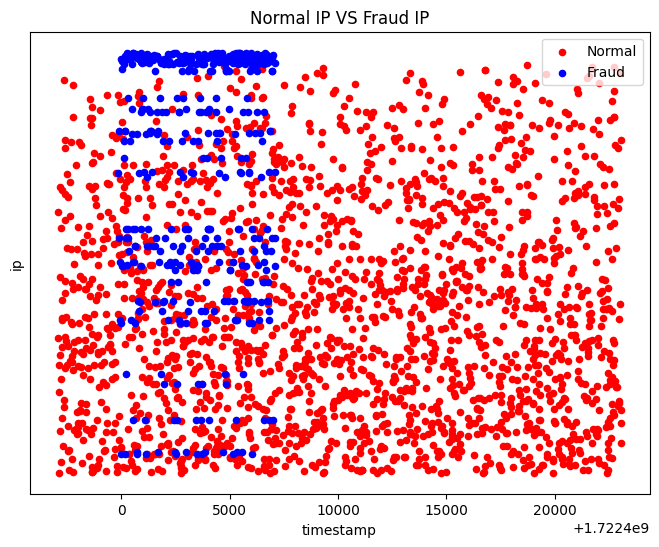

In [9]:
import matplotlib.ticker as ticker

plt.figure(figsize=(8, 6))

x0 = ip_df[ip_df['label'] == 0]['timestamp'].tolist()
y0 = ip_df[ip_df['label'] == 0]['ipv4'].tolist()
x1 = ip_df[ip_df['label'] == 1]['timestamp'].tolist()
y1 = ip_df[ip_df['label'] == 1]['ipv4'].tolist()

plt.scatter(x0, y0, s=20, color='red', label='Normal')
plt.scatter(x1, y1, s=20, color='blue', label='Fraud')

plt.yticks([])

plt.title('Normal IP VS Fraud IP')
plt.xlabel('timestamp')
plt.ylabel('ip')
plt.legend(loc='upper right')
plt.show()